In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEClustering
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEClustering
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import density_silhouette

from matplotlib import cm

In [3]:
cmaps = (cm.Blues, cm.Oranges)
colors = ('cornflowerblue', 'goldenrod')

In [4]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

# Dane

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

## Treningowe

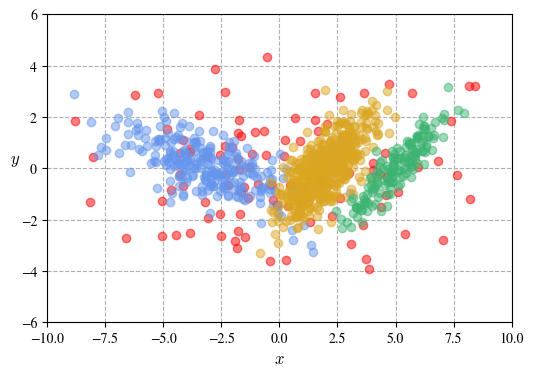

In [5]:
np.random.seed(1)

# Data
n_experiments = 100
m_train = 1000
n_x, n_y = 1, 1

# Class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
# Class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
# Class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
# Class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]

z_train = np.empty((n_experiments, m_train, n_x + n_y))
labels_train1 = np.full(m_train1, 1, dtype=np.int32)
labels_train2 = np.full(m_train2, 2, dtype=np.int32)
labels_train3 = np.full(m_train3, 3, dtype=np.int32)
labels_train4 = np.full(m_train4, 4, dtype=np.int32)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

for e in range(n_experiments):
    # Class 1
    z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
    # Class 2
    z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
    # Class 3
    z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
    # Class 4
    z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)

    z_train[e, :, :] = np.concatenate((z_train1, z_train2, z_train3, z_train4), axis=0)

x_train = z_train[:, :, [0]]
y_train = z_train[:, :, [1]]


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[0, -m_train4:], y_train[0, -m_train4:], c="red", zorder=2, alpha=0.5)
plt.scatter(x_train[0, :m_train1], y_train[0, :m_train1], c="cornflowerblue", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1:m_train1+m_train2], y_train[0, m_train1:m_train1+m_train2], c="goldenrod", zorder=2, alpha=0.5)
plt.scatter(x_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], y_train[0, m_train1+m_train2:m_train1+m_train2+m_train3], c="mediumseagreen", zorder=2, alpha=0.5)

plt.xlim(-10, 10)
plt.ylim(-6, 6)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
plt.show()

In [6]:
bandwidth_z = np.zeros((n_experiments, n_x + n_y))
for e in range(n_experiments):
    bandwidth_z[e] = direct_plugin(z_train[e])
bandwidth_x = bandwidth_z[:, :n_x]
bandwidth_y = bandwidth_z[:, n_x:]

x_grid = np.linspace(-10, 10, 1000)[:, None]

\newpage

# Ujęcie bezwarunkowe

## Pojedynczy eksperyment

n_clusters: 3
Wskaźnik jakości [mean dbs]: 0.201591


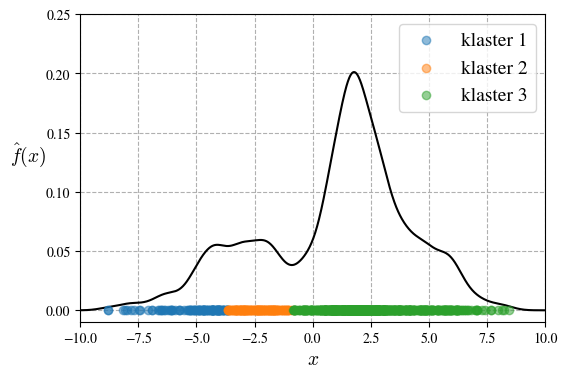

In [7]:
kde = KDE().fit(x_train[0], bandwidth=bandwidth_x[0])
scores = kde.pdf(x_grid)

kde_clustering = KDEClustering().fit(x_train[0], bandwidth=bandwidth_x[0])
labels_pred = kde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
for label in np.unique(labels_pred):
    plt.scatter(x_train[0, labels_pred==label], x_train[0, labels_pred==label]*0, alpha=0.5, zorder=2, label=f"klaster {label+1}")

plt.legend(fontsize=14)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=14)
plt.xlim(-10, 10)
plt.ylim(top=0.25)
plt.grid(linestyle="--")

# plt.savefig("synthetic_data_clustering_kde.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

### Dopasowanie $h$ na siatce

In [8]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [9]:
best_metric = -np.inf
for h_mul in h_mul_grid:
    kde_clustering = KDEClustering().fit(x_train[0], bandwidth=bandwidth_x[0] * h_mul)
    labels_pred = kde_clustering.predict(x_train[0])
    dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred)
    if mean_dbs > best_metric:
        best_h_mul = h_mul
        best_metric = mean_dbs

print(f"Najlepszy mnożnik h: {best_h_mul:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h: 0.70
Przy wskaźniku jakości: 0.376569


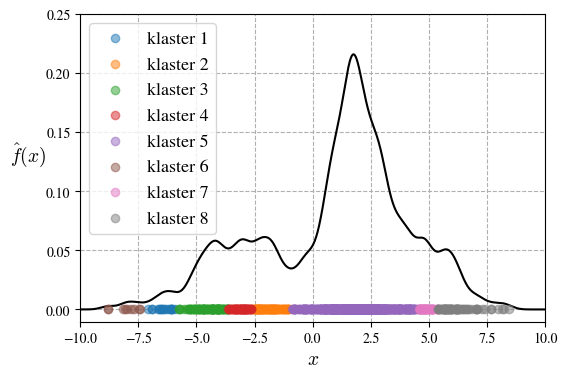

In [12]:
kde = KDE().fit(x_train[0], bandwidth=bandwidth_x[0] * best_h_mul)
scores = kde.pdf(x_grid)

kde_clustering = KDEClustering().fit(x_train[0], bandwidth=bandwidth_x[0] * best_h_mul)
labels_pred = kde_clustering.predict(x_train[0])


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
for label in np.unique(labels_pred):
    plt.scatter(x_train[0, labels_pred==label], x_train[0, labels_pred==label]*0, alpha=0.5, zorder=2, label=f"klaster {label+1}")

plt.legend(fontsize=13)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=14)
plt.xlim(-10, 10)
plt.ylim(top=0.25)
plt.grid(linestyle="--")

# plt.savefig("synthetic_data_clustering_kde2.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

## Wielokrotne eksperymenty

In [13]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    kde_clustering = KDEClustering().fit(x_train[e], bandwidth=bandwidth_x[e])
    labels_pred = kde_clustering.predict(x_train[e])
    dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred)
    metrics[e] = mean_dbs

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 100 eksperymentów [mean dbs]: 0.263886 +- 0.104383


### Dopasowanie $h$ na siatce

In [12]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [13]:
best_metrics = np.empty((n_experiments,))
best_h_muls = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = -np.inf
    for h_mul in h_mul_grid:
        kde_clustering = KDEClustering().fit(x_train[e], bandwidth=bandwidth_x[e] * h_mul)
        labels_pred = kde_clustering.predict(x_train[e])
        dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred)
        if mean_dbs > best_metric:
            best_metric = mean_dbs
            best_h_mul = h_mul
    best_metrics[e] = best_metric
    best_h_muls[e] = best_h_mul

    
print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")
print(f"Średni najlepszy mnożnik h: {np.mean(best_h_muls):.6f} +- {np.std(best_h_muls):.6f}")

Wskaźnik jakości dla 100 eksperymentów [mean dbs]: 0.369542 +- 0.063988
Średni najlepszy mnożnik h: 0.920000 +- 0.352987


\newpage

# Ujęcie warunkowe

## $y^*=-2.0$

In [35]:
y_star = np.array([-2.0])

n_clusters: 8
Wskaźnik jakości [mean dbs]: 0.190984


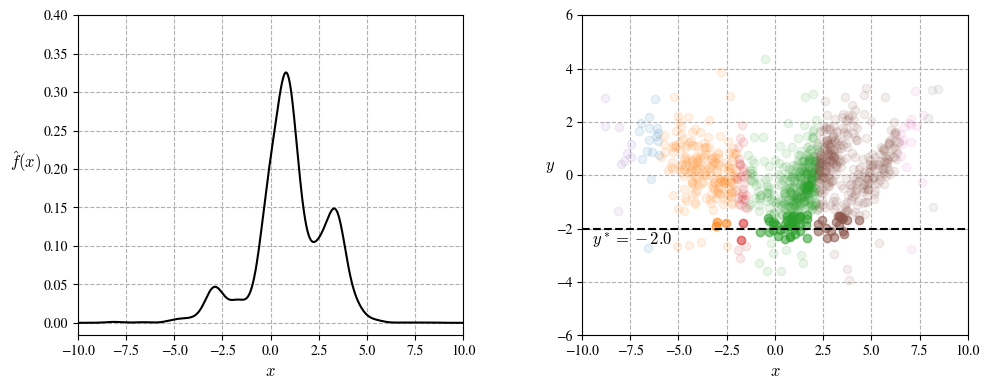

In [36]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.5, -2.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

\newpage

### Dopasowanie $h$ na siatce

In [16]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [37]:
best_metric = -np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                               bandwidth_x=bandwidth_x[0] * h_mul_x, bandwidth_y=bandwidth_y[0] * h_mul_y)
        labels_pred = ckde_clustering.predict(x_train[0])
        dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
        if mean_dbs > best_metric:
            best_h_mul_x = h_mul_x
            best_h_mul_y = h_mul_y
            best_metric = mean_dbs

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h_x: 2.00, h_y: 1.40
Przy wskaźniku jakości: 1.000000


n_clusters: 1
Wskaźnik jakości [mean dbs]: 1.000000


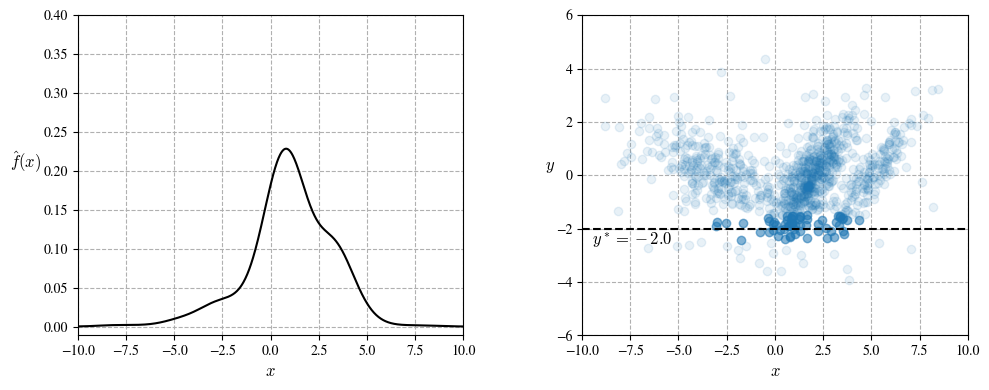

In [38]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.5, -2.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

## $y^*=-2.0$ - wielokrotne eksperymenty

In [39]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                           bandwidth_x=bandwidth_x[e], bandwidth_y=bandwidth_y[e])
    labels_pred = ckde_clustering.predict(x_train[e])
    dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
    metrics[e] = mean_dbs

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 100 eksperymentów [mean dbs]: 0.217431 +- 0.134996


### Dopasowanie $h$ na siatce

In [20]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [40]:
best_metrics = np.empty((n_experiments,))
best_h_muls_x = np.empty((n_experiments,))
best_h_muls_y = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = -np.inf
    for h_mul_x in h_mul_grid:
        for h_mul_y in h_mul_grid:
            ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                                   bandwidth_x=bandwidth_x[e] * h_mul_x,
                                                   bandwidth_y=bandwidth_y[e] * h_mul_y)
            labels_pred = ckde_clustering.predict(x_train[e])
            dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
            if mean_dbs > best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_metric = mean_dbs
                
    best_metrics[e] = best_metric
    best_h_muls_x[e] = best_h_mul_x
    best_h_muls_y[e] = best_h_mul_y

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")
print(f"Średni najlepszy mnożnik h_x: {np.mean(best_h_muls_x):.6f} +- {np.std(best_h_muls_x):.6f}")
print(f"Średni najlepszy mnożnik h_y: {np.mean(best_h_muls_y):.6f} +- {np.std(best_h_muls_y):.6f}")

\newpage

## $y^*=0.0$

In [41]:
y_star = np.array([0.0])

n_clusters: 5
Wskaźnik jakości [mean dbs]: 0.086383


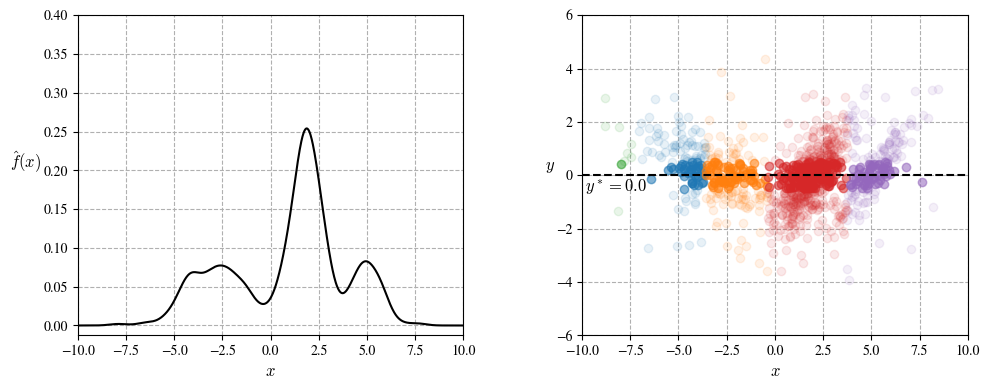

In [42]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.85, -0.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

\newpage

### Dopasowanie $h$ na siatce

In [43]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [44]:
best_metric = -np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                               bandwidth_x=bandwidth_x[0] * h_mul_x, bandwidth_y=bandwidth_y[0] * h_mul_y)
        labels_pred = ckde_clustering.predict(x_train[0])
        dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
        if mean_dbs > best_metric:
            best_h_mul_x = h_mul_x
            best_h_mul_y = h_mul_y
            best_metric = mean_dbs

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h_x: 0.90, h_y: 0.70
Przy wskaźniku jakości: 0.476420


n_clusters: 6
Wskaźnik jakości [mean dbs]: 0.476420


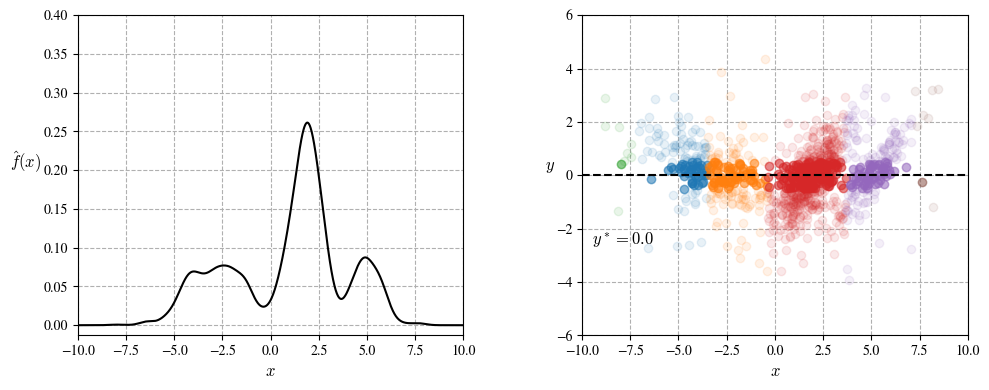

In [45]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.5, -2.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

## $y^*=0.0$ - wielokrotne eksperymenty

In [46]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                           bandwidth_x=bandwidth_x[e], bandwidth_y=bandwidth_y[e])
    labels_pred = ckde_clustering.predict(x_train[e])
    dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
    metrics[e] = mean_dbs

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 100 eksperymentów [mean dbs]: 0.169223 +- 0.104135


### Dopasowanie $h$ na siatce

In [47]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [48]:
best_metrics = np.empty((n_experiments,))
best_h_muls_x = np.empty((n_experiments,))
best_h_muls_y = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = -np.inf
    for h_mul_x in h_mul_grid:
        for h_mul_y in h_mul_grid:
            ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                                   bandwidth_x=bandwidth_x[e] * h_mul_x,
                                                   bandwidth_y=bandwidth_y[e] * h_mul_y)
            labels_pred = ckde_clustering.predict(x_train[e])
            dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
            if mean_dbs > best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_metric = mean_dbs
                
    best_metrics[e] = best_metric
    best_h_muls_x[e] = best_h_mul_x
    best_h_muls_y[e] = best_h_mul_y

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")
print(f"Średni najlepszy mnożnik h_x: {np.mean(best_h_muls_x):.6f} +- {np.std(best_h_muls_x):.6f}")
print(f"Średni najlepszy mnożnik h_y: {np.mean(best_h_muls_y):.6f} +- {np.std(best_h_muls_y):.6f}")

\newpage

## $y^*=2.0$

In [49]:
y_star = np.array([2.0])

n_clusters: 6
Wskaźnik jakości [mean dbs]: 0.369778


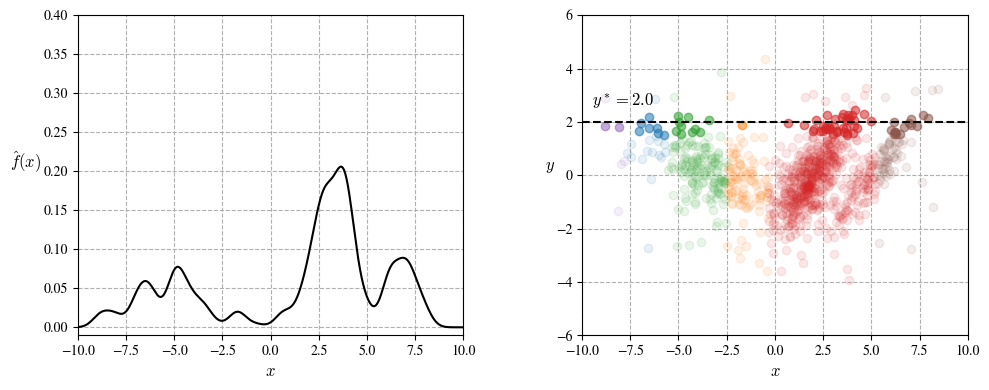

In [50]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.5, 2.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

\newpage

### Dopasowanie $h$ na siatce

In [51]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [52]:
best_metric = -np.inf
for h_mul_x in h_mul_grid:
    for h_mul_y in h_mul_grid:
        ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                               bandwidth_x=bandwidth_x[0] * h_mul_x, bandwidth_y=bandwidth_y[0] * h_mul_y)
        labels_pred = ckde_clustering.predict(x_train[0])
        dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
        if mean_dbs > best_metric:
            best_h_mul_x = h_mul_x
            best_h_mul_y = h_mul_y
            best_metric = mean_dbs

print(f"Najlepszy mnożnik h_x: {best_h_mul_x:.2f}, h_y: {best_h_mul_y:.2f}")
print(f"Przy wskaźniku jakości: {best_metric:.6f}")

Najlepszy mnożnik h_x: 1.80, h_y: 0.50
Przy wskaźniku jakości: 0.425931


n_clusters: 4
Wskaźnik jakości [mean dbs]: 0.425931


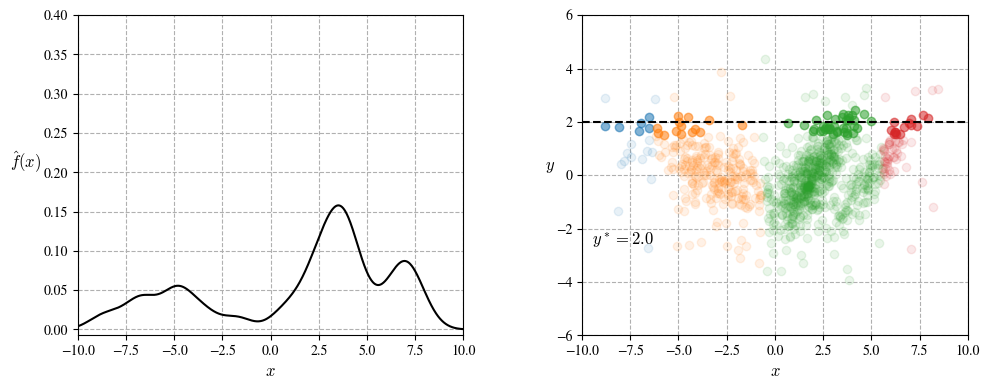

In [53]:
ckde = CKDE().fit(x_train[0], y_train[0], y_star,
                  bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
scores = ckde.pdf(x_grid)

ckde_clustering = CKDEClustering().fit(x_train[0], y_train[0], y_star,
                                       bandwidth_x=bandwidth_x[0] * best_h_mul_x, bandwidth_y=bandwidth_y[0] * best_h_mul_y)
labels_pred = ckde_clustering.predict(x_train[0])
print(f"n_clusters: {np.unique(labels_pred).size}")

dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred, ckde_clustering.cond_weights_train)
print(f"Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)


axs[0].plot(x_grid, scores, c="k")

axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")


for label in np.unique(labels_pred):
    axs[1].scatter(x_train[0, labels_pred==label], y_train[0, labels_pred==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred==label) & (y_train[0, :, 0] > y_star[0] - 0.5) & (y_train[0, :, 0] < y_star[0] + 0.5)
    axs[1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1].hlines(y_star[0], -10, 10, color="k", linestyle="--")
axs[1].text(-9.5, -2.6, f"$y^*={y_star[0]}$", fontsize=12)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-6, 6)
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1].grid(linestyle="--")


plt.tight_layout(w_pad=5)
plt.show()

## $y^*=2.0$ - wielokrotne eksperymenty

In [54]:
metrics = np.empty((n_experiments,))
for e in range(n_experiments):
    ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                           bandwidth_x=bandwidth_x[e], bandwidth_y=bandwidth_y[e])
    labels_pred = ckde_clustering.predict(x_train[e])
    dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
    metrics[e] = mean_dbs

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(metrics):.6f} +- {np.std(metrics):.6f}")

Wskaźnik jakości dla 100 eksperymentów [mean dbs]: 0.229442 +- 0.123916


### Dopasowanie $h$ na siatce

In [55]:
h_mul_grid = (1.0, 0.9, 1.2, 0.8, 1.4, 0.7, 1.6, 0.6, 1.8, 0.5, 2.0)

print(f"Siatka dla mnożników h: {sorted(h_mul_grid)}")

Siatka dla mnożników h: [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


In [56]:
best_metrics = np.empty((n_experiments,))
best_h_muls_x = np.empty((n_experiments,))
best_h_muls_y = np.empty((n_experiments,))
for e in range(n_experiments):
    
    best_metric = -np.inf
    for h_mul_x in h_mul_grid:
        for h_mul_y in h_mul_grid:
            ckde_clustering = CKDEClustering().fit(x_train[e], y_train[e], y_star,
                                                   bandwidth_x=bandwidth_x[e] * h_mul_x,
                                                   bandwidth_y=bandwidth_y[e] * h_mul_y)
            labels_pred = ckde_clustering.predict(x_train[e])
            dbs_scores, mean_dbs = density_silhouette(x_train[e], labels_pred, ckde_clustering.cond_weights_train)
            if mean_dbs > best_metric:
                best_h_mul_x = h_mul_x
                best_h_mul_y = h_mul_y
                best_metric = mean_dbs
                
    best_metrics[e] = best_metric
    best_h_muls_x[e] = best_h_mul_x
    best_h_muls_y[e] = best_h_mul_y

print(f"Wskaźnik jakości dla {n_experiments} eksperymentów [mean dbs]: {np.mean(best_metrics):.6f} +- {np.std(best_metrics):.6f}")
print(f"Średni najlepszy mnożnik h_x: {np.mean(best_h_muls_x):.6f} +- {np.std(best_h_muls_x):.6f}")
print(f"Średni najlepszy mnożnik h_y: {np.mean(best_h_muls_y):.6f} +- {np.std(best_h_muls_y):.6f}")

\newpage

## Rysunki

### Podstawa

[neg] n_clusters: 8
[neg] Wskaźnik jakości [mean dbs]: 0.190984
[neu] n_clusters: 5
[neu] Wskaźnik jakości [mean dbs]: 0.086383
[pos] n_clusters: 6
[pos] Wskaźnik jakości [mean dbs]: 0.369778


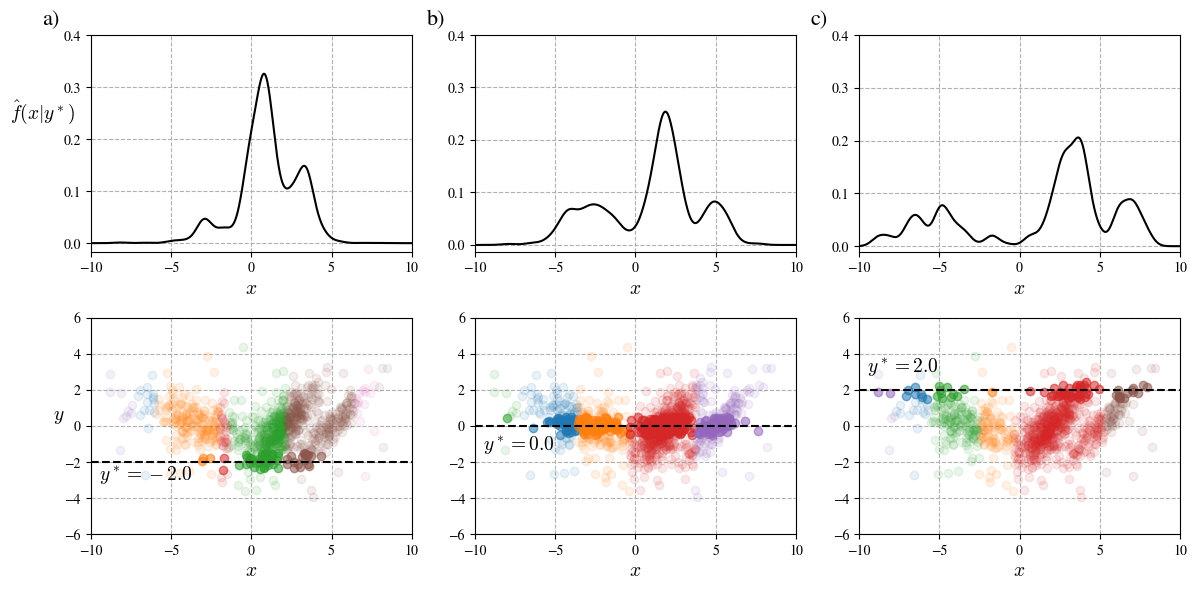

In [70]:
y_star_neg = np.array([-2.0])
y_star_neu = np.array([0.0])
y_star_pos = np.array([2.0])


ckde_neg = CKDE().fit(x_train[0], y_train[0], y_star_neg,
                      bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores_neg = ckde_neg.pdf(x_grid)
ckde_clustering_neg = CKDEClustering().fit(x_train[0], y_train[0], y_star_neg,
                                           bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred_neg = ckde_clustering_neg.predict(x_train[0])
print(f"[neg] n_clusters: {np.unique(labels_pred_neg).size}")
# cond = (y_train[0, :, 0] > y_star_neg[0] - 0.5) & (y_train[0, :, 0] < y_star_neg[0] + 0.5)
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_neg, ckde_clustering_neg.cond_weights_train)
print(f"[neg] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")

ckde_neu = CKDE().fit(x_train[0], y_train[0], y_star_neu,
                      bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores_neu = ckde_neu.pdf(x_grid)
ckde_clustering_neu = CKDEClustering().fit(x_train[0], y_train[0], y_star_neu,
                                           bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred_neu = ckde_clustering_neu.predict(x_train[0])
print(f"[neu] n_clusters: {np.unique(labels_pred_neu).size}")
# cond = (y_train[0, :, 0] > y_star_neu[0] - 0.5) & (y_train[0, :, 0] < y_star_neu[0] + 0.5)
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_neu, ckde_clustering_neu.cond_weights_train)
print(f"[neu] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")

ckde_pos = CKDE().fit(x_train[0], y_train[0], y_star_pos,
                      bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
scores_pos = ckde_pos.pdf(x_grid)
ckde_clustering_pos = CKDEClustering().fit(x_train[0], y_train[0], y_star_pos,
                                           bandwidth_x=bandwidth_x[0], bandwidth_y=bandwidth_y[0])
labels_pred_pos = ckde_clustering_pos.predict(x_train[0])
print(f"[pos] n_clusters: {np.unique(labels_pred_pos).size}")
# cond = (y_train[0, :, 0] > y_star_pos[0] - 0.5) & (y_train[0, :, 0] < y_star_pos[0] + 0.5)
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_pos, ckde_clustering_pos.cond_weights_train)
print(f"[pos] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi=100)


axs[0, 0].plot(x_grid, scores_neg, c="k")
axs[0, 0].text(-13.0, 0.42, "a)", fontsize=16)
axs[0, 0].set_xlabel("$x$", fontsize=14)
axs[0, 0].set_ylabel("$\hat{f}(x|y^*)$", rotation=0, labelpad=13, fontsize=14)
axs[0, 0].yaxis.set_label_coords(-0.15, 0.58)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=0.4)
axs[0, 0].grid(linestyle="--")

for label in np.unique(labels_pred_neg):
    axs[1, 0].scatter(x_train[0, labels_pred_neg==label], y_train[0, labels_pred_neg==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_neg==label) & (y_train[0, :, 0] > y_star_neg[0] - 0.5) & (y_train[0, :, 0] < y_star_neg[0] + 0.5)
    axs[1, 0].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 0].hlines(y_star_neg[0], -10, 10, color="k", linestyle="--")
axs[1, 0].text(-9.5, -3, f"$y^*={y_star_neg[0]}$", fontsize=14)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(-6, 6)
axs[1, 0].set_xlabel("$x$", fontsize=14)
axs[1, 0].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1, 0].grid(linestyle="--")


axs[0, 1].plot(x_grid, scores_neu, c="k")
axs[0, 1].text(-13.0, 0.42, "b)", fontsize=16)
axs[0, 1].set_xlabel("$x$", fontsize=14)
# axs[0, 1].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_ylim(top=0.4)
axs[0, 1].grid(linestyle="--")

for label in np.unique(labels_pred_neu):
    axs[1, 1].scatter(x_train[0, labels_pred_neu==label], y_train[0, labels_pred_neu==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_neu==label) & (y_train[0, :, 0] > y_star_neu[0] - 0.5) & (y_train[0, :, 0] < y_star_neu[0] + 0.5)
    axs[1, 1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 1].hlines(y_star_neu[0], -10, 10, color="k", linestyle="--")
axs[1, 1].text(-9.5, -1.3, f"$y^*={y_star_neu[0]}$", fontsize=14)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_ylim(-6, 6)
axs[1, 1].set_xlabel("$x$", fontsize=14)
# axs[1, 1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 1].grid(linestyle="--")


axs[0, 2].plot(x_grid, scores_pos, c="k")
axs[0, 2].text(-13.0, 0.42, "c)", fontsize=16)
axs[0, 2].set_xlabel("$x$", fontsize=14)
# axs[0, 2].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0, 2].set_xlim(-10, 10)
axs[0, 2].set_ylim(top=0.4)
axs[0, 2].grid(linestyle="--")

for label in np.unique(labels_pred_pos):
    axs[1, 2].scatter(x_train[0, labels_pred_pos==label], y_train[0, labels_pred_pos==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_pos==label) & (y_train[0, :, 0] > y_star_pos[0] - 0.5) & (y_train[0, :, 0] < y_star_pos[0] + 0.5)
    axs[1, 2].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 2].hlines(y_star_pos[0], -10, 10, color="k", linestyle="--")
axs[1, 2].text(-9.5, 3, f"$y^*={y_star_pos[0]}$", fontsize=14)
axs[1, 2].set_xlim(-10, 10)
axs[1, 2].set_ylim(-6, 6)
axs[1, 2].set_xlabel("$x$", fontsize=14)
# axs[1, 2].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 2].grid(linestyle="--")


plt.tight_layout()
# plt.savefig("synthetic_data_clustering_ckde.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Dopasowanie

[neg] n_clusters: 1
[neg] Wskaźnik jakości [mean dbs]: 1.000000
[neu] n_clusters: 6
[neu] Wskaźnik jakości [mean dbs]: 0.476420
[pos] n_clusters: 4
[pos] Wskaźnik jakości [mean dbs]: 0.425931


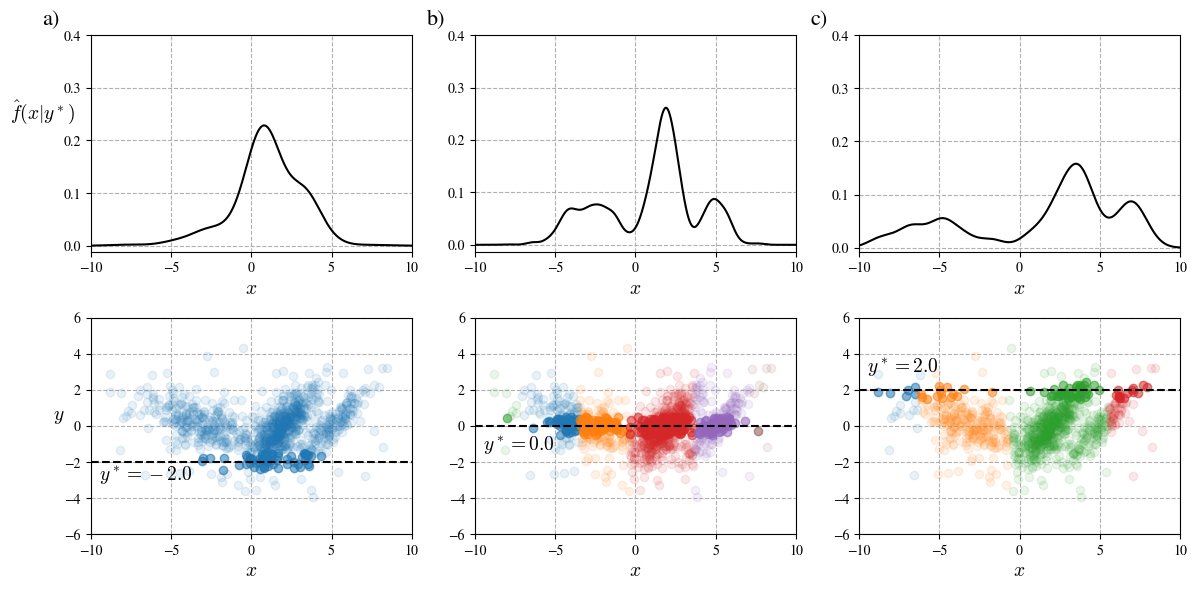

In [72]:
y_star_neg = np.array([-2.0])
y_star_neu = np.array([0.0])
y_star_pos = np.array([2.0])


ckde_neg = CKDE().fit(x_train[0], y_train[0], y_star_neg,
                      bandwidth_x=bandwidth_x[0] * 2.0, bandwidth_y=bandwidth_y[0] * 1.4)
scores_neg = ckde_neg.pdf(x_grid)
ckde_clustering_neg = CKDEClustering().fit(x_train[0], y_train[0], y_star_neg,
                                           bandwidth_x=bandwidth_x[0] * 2.0, bandwidth_y=bandwidth_y[0] * 1.4)
labels_pred_neg = ckde_clustering_neg.predict(x_train[0])
print(f"[neg] n_clusters: {np.unique(labels_pred_neg).size}")
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_neg, ckde_clustering_neg.cond_weights_train)
print(f"[neg] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")

ckde_neu = CKDE().fit(x_train[0], y_train[0], y_star_neu,
                      bandwidth_x=bandwidth_x[0] * 0.9, bandwidth_y=bandwidth_y[0] * 0.7)
scores_neu = ckde_neu.pdf(x_grid)
ckde_clustering_neu = CKDEClustering().fit(x_train[0], y_train[0], y_star_neu,
                                           bandwidth_x=bandwidth_x[0] * 0.9, bandwidth_y=bandwidth_y[0] * 0.7)
labels_pred_neu = ckde_clustering_neu.predict(x_train[0])
print(f"[neu] n_clusters: {np.unique(labels_pred_neu).size}")
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_neu, ckde_clustering_neu.cond_weights_train)
print(f"[neu] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")

ckde_pos = CKDE().fit(x_train[0], y_train[0], y_star_pos,
                      bandwidth_x=bandwidth_x[0] * 1.8, bandwidth_y=bandwidth_y[0] * 0.5)
scores_pos = ckde_pos.pdf(x_grid)
ckde_clustering_pos = CKDEClustering().fit(x_train[0], y_train[0], y_star_pos,
                                           bandwidth_x=bandwidth_x[0] * 1.8, bandwidth_y=bandwidth_y[0] * 0.5)
labels_pred_pos = ckde_clustering_pos.predict(x_train[0])
print(f"[pos] n_clusters: {np.unique(labels_pred_pos).size}")
dbs_scores, mean_dbs = density_silhouette(x_train[0], labels_pred_pos, ckde_clustering_pos.cond_weights_train)
print(f"[pos] Wskaźnik jakości [mean dbs]: {mean_dbs:.6f}")


# Plot
fig, axs = plt.subplots(2, 3, figsize=(12, 6), dpi=100)


axs[0, 0].plot(x_grid, scores_neg, c="k")
axs[0, 0].text(-13.0, 0.42, "a)", fontsize=16)
axs[0, 0].set_xlabel("$x$", fontsize=14)
axs[0, 0].set_ylabel("$\hat{f}(x|y^*)$", rotation=0, labelpad=13, fontsize=14)
axs[0, 0].yaxis.set_label_coords(-0.15, 0.58)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylim(top=0.4)
axs[0, 0].grid(linestyle="--")

for label in np.unique(labels_pred_neg):
    axs[1, 0].scatter(x_train[0, labels_pred_neg==label], y_train[0, labels_pred_neg==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_neg==label) & (y_train[0, :, 0] > y_star_neg[0] - 0.5) & (y_train[0, :, 0] < y_star_neg[0] + 0.5)
    axs[1, 0].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 0].hlines(y_star_neg[0], -10, 10, color="k", linestyle="--")
axs[1, 0].text(-9.5, -3, f"$y^*={y_star_neg[0]}$", fontsize=14)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylim(-6, 6)
axs[1, 0].set_xlabel("$x$", fontsize=14)
axs[1, 0].set_ylabel("$y$", rotation=0, fontsize=14)
axs[1, 0].grid(linestyle="--")


axs[0, 1].plot(x_grid, scores_neu, c="k")
axs[0, 1].text(-13.0, 0.42, "b)", fontsize=16)
axs[0, 1].set_xlabel("$x$", fontsize=14)
# axs[0, 1].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_ylim(top=0.4)
axs[0, 1].grid(linestyle="--")

for label in np.unique(labels_pred_neu):
    axs[1, 1].scatter(x_train[0, labels_pred_neu==label], y_train[0, labels_pred_neu==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_neu==label) & (y_train[0, :, 0] > y_star_neu[0] - 0.5) & (y_train[0, :, 0] < y_star_neu[0] + 0.5)
    axs[1, 1].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 1].hlines(y_star_neu[0], -10, 10, color="k", linestyle="--")
axs[1, 1].text(-9.5, -1.3, f"$y^*={y_star_neu[0]}$", fontsize=14)
axs[1, 1].set_xlim(-10, 10)
axs[1, 1].set_ylim(-6, 6)
axs[1, 1].set_xlabel("$x$", fontsize=14)
# axs[1, 1].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 1].grid(linestyle="--")


axs[0, 2].plot(x_grid, scores_pos, c="k")
axs[0, 2].text(-13.0, 0.42, "c)", fontsize=16)
axs[0, 2].set_xlabel("$x$", fontsize=14)
# axs[0, 2].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
axs[0, 2].set_xlim(-10, 10)
axs[0, 2].set_ylim(top=0.4)
axs[0, 2].grid(linestyle="--")

for label in np.unique(labels_pred_pos):
    axs[1, 2].scatter(x_train[0, labels_pred_pos==label], y_train[0, labels_pred_pos==label], alpha=0.1, zorder=2, c=f"C{label}")
    cond = (labels_pred_pos==label) & (y_train[0, :, 0] > y_star_pos[0] - 0.5) & (y_train[0, :, 0] < y_star_pos[0] + 0.5)
    axs[1, 2].scatter(x_train[0, cond], y_train[0, cond], alpha=0.5, zorder=2, c=f"C{label}")
axs[1, 2].hlines(y_star_pos[0], -10, 10, color="k", linestyle="--")
axs[1, 2].text(-9.5, 3, f"$y^*={y_star_pos[0]}$", fontsize=14)
axs[1, 2].set_xlim(-10, 10)
axs[1, 2].set_ylim(-6, 6)
axs[1, 2].set_xlabel("$x$", fontsize=14)
# axs[1, 2].set_ylabel("$y$", rotation=0, fontsize=12)
axs[1, 2].grid(linestyle="--")

plt.tight_layout()
# plt.savefig("synthetic_data_clustering_ckde2.pdf", format="pdf", bbox_inches="tight")
plt.show()